# Computer Vision Project - Classification of Flowers


In this project your objective is to create a model in order to classify flowers. Thiszip file contains all relevant data. 

1. The data contains two folders: *train* and *test*. The *train* folder consists of 5486-images to use for training while the *test* folder contains 1351-images you can use to test your model in a **train-test-split** validation style. We have omitted another set of 1352 validation images which we will use to benchmark your final models in the last lecture. 


2. We have provided you with two label files: *train_labels.csv* and *test_labels.csv*. Each file contains the filename of the corresponding image and the class label. In total we have **102 different classes** of flowers.  You can import the label files using the `import_labels()` function provided to you in this notebook.


3. Due to the large number of images, there is a good chance that you can not easily fit the entire training and testing data into RAM. We therefore give you an implementation of a `DataGenerator` class that can be used with keras. This class will read in the images from your hard-drive for each batch during during or testing. The class comes with some nice features that could improve your training significantly such as **image resizing**, **data augmentation** and **preprocessing**. Have a look at the code to find out how.

    Initialize data generators using labels and image source directory.

    `
    datagen_train = DataGenerator('train', y_train, batch_size, input_shape, ...)
    datagen_test = DataGenerator('test', y_test, batch_size, input_shape, ...)`

    Train your model using data generators.

    `model.fit(datagen_train, validation_data=datagen_test, ...)`
    
    
4. Select a suitable model for classification. It is up to you to decide all model parameters, such as **number of layers**, **number and size of filter** in each layer, using **pooling** or, **image-size**, **data-augmentation**, **learning rate**, ... 


5. **Document** your progress and your intermediate results (your failures and improvements). Describe why you selected certain model and training parameters, what worked, what did not work. Store the training history (loss and accuracy) and create corresponding plots. This documentation will be part of your final presentation and will be **graded**.


6. Feel free to explore the internet for suitable CNN models and re-use these ideas. If you use certain features we have not touched during the lecture such as Dropout, Residual Learning or Batch Normalization. Prepare a slide in your final presentation to explain in your own (basic) terms what these things to so we can all learn from your experience. **Notice:** Very large models might perform better but will be harder and slower to train. **Do not use a pre-trained model on the flower dataset you find online!** You are however allowed to use techniques like transfer learning or refinement (i.e. using models pre-trained on different datasets). 


7. Prepare a notebook with your model such that we can use it in the final competition. This means, store your trained model using `model.save(...)`. Your saved models can be loaded via `tf.keras.models.load_model(...)`. We will then provide you with a new folder containing images (*validation*) and a file containing labels (*validation_labels.csv*) which have the same structure. Prepare a data generator for this validation data (test it using the test data) and supply it to the 
 `evaluate_model(model, datagen)` function provided to you.
 
 Your prepared notebook could look like this:
 
    `... import stuff 
    ... code to load the stored model ...
    y_validation = import_labels('validation_labels.csv')
    datagen_validation = DataGenerator('validation', y_validation, batch_size, input_shape)
    evaluate_model(model, datagen_validation)`


8. Prepare a 15-Minute presentation of your findings and final model presentation. A rough guideline what could be interesting to your audience:
    * Explain your models architecture (number of layers, number of total parameters, how long took it to train, ...)
    * Compare the training history of your experimentats visually
    * Explain your best model (why is it better)
    * Why did you take certain decision (parameters, image size, batch size, ...)
    * What worked, what did not work (any ideas why?)
    * **What did you learn?**
    



In [10]:
# Read in label file and return a dictionary {'filename' : label}.
#
def import_labels(label_file):
    labels = dict()

    import csv
    with open(label_file) as fd:
        csvreader = csv.DictReader(fd)

        for row in csvreader:
            labels[row['filename']] = int(row['label'])
    return labels

In [11]:

import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt


class DataGenerator(keras.utils.Sequence):

    '''
        img_root_dir - path to images
        labels_dict - dict with labels of data
        batch_size - batch
        target_dim - target dimension for our images to scale to
        preprocess_func=None
        use_augmentation=False - augumentation for extra data
        do_shuffling=False - turns off shuffling of data
    '''
    def __init__(self, img_root_dir, labels_dict, batch_size, target_dim, preprocess_func=None, use_augmentation=False, do_shuffling=False):
        self._labels_dict = labels_dict
        self._img_root_dir = img_root_dir
        self._batch_size = batch_size
        self._target_dim = target_dim
        self._preprocess_func = preprocess_func
        self._n_classes = len(set(self._labels_dict.values()))
        self._fnames_all = list(self._labels_dict.keys())
        self._use_augmentation = use_augmentation
        self._do_shuffling = do_shuffling

        if self._use_augmentation:
            self._augmentor =  keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self._fnames_all)) / self._batch_size)

    def on_epoch_end(self):
        self._indices = np.arange(len(self._fnames_all))
        if(self._do_shuffling):
            np.random.shuffle(self._indices)

    def __getitem__(self, index):
        indices = self._indices[index * self._batch_size:(index + 1) * self._batch_size]

        fnames = [self._fnames_all[k] for k in indices]
        X, Y = self.__load_files__(fnames)

        return X, Y

    def __load_files__(self, batch_filenames):
        X = np.empty((self._batch_size, *self._target_dim, 3))
        Y = np.empty((self._batch_size), dtype=int)

        for idx, fname in enumerate(batch_filenames):
            img_path = os.path.join(self._img_root_dir, fname)
            img =  keras.preprocessing.image.load_img(img_path, target_size=self._target_dim)
            x =  keras.preprocessing.image.img_to_array(img)

            if self._preprocess_func is not None:
                x = self._preprocess_func(x)

            X[idx, :] = x
            Y[idx] = self._labels_dict[fname] - 1

        if self._use_augmentation:
            it = self._augmentor.flow(X, batch_size=self._batch_size, shuffle=False)
            X = it.next()

        return X, keras.utils.to_categorical(Y, num_classes=self._n_classes)


In [12]:

def create_model(input_shape):
    # model CNN
    model = keras.Sequential()
    # we have to tell keras the correct input shape aka the dimension of our images
    model.add(keras.Input(shape=(input_shape, input_shape, 3)))
    # instead of 32 -> our target dimension

    # add a convolution layer with 16 filters, filters of size 3x3 and relu as activation Recitified Linear Unit
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D(2, 2))

    # add a convolution layer with 16 filters, filters of size 3x3 and relu as activation (whatever relu is)
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D(2, 2))

    # convert to fully-connected network
    model.add(keras.layers.Flatten())

    # add classifier part
    model.add(keras.layers.Dense(input_shape, activation='relu'))
    model.add(keras.layers.Dense(input_shape, activation='relu'))

    # number of output neurons must be equal to number of classes
    model.add(keras.layers.Dense(102, activation='softmax'))


    model.summary()
    # keras.utils.plot_model(model, "my_first_model.png")

    return model


In [13]:
# 1351
TEST_LABELS_PATH = 'data/test_labels.csv'
TEST_IMAGES_PATH = 'data/test'

# 5486
TRAIN_LABELS_PATH = 'data/train_labels.csv'
TRAIN_IMAGES_PATH = 'data/train'

# 224
input_shape = 224

In [17]:
train_labels = import_labels(TRAIN_LABELS_PATH)
test_labels = import_labels(TEST_LABELS_PATH)


# if batch size is not the divider of total numbers of images, the DataGenerator will cut the reminder (ergo there will be too little for model.prediction)
datagen_train = DataGenerator(img_root_dir=TRAIN_IMAGES_PATH,
                              labels_dict=train_labels,
                              batch_size=10,
                              target_dim=(input_shape, input_shape))
datagen_test = DataGenerator(img_root_dir=TEST_IMAGES_PATH,
                              labels_dict=test_labels,
                              batch_size=7,
                              target_dim=(input_shape, input_shape))
print(len(datagen_test))

193


In [18]:
model = create_model(input_shape)

# compiling  model
loss_fn = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])





Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 46656)             0         
                                                                 
 dense_12 (Dense)            (None, 224)              

In [19]:
# trining
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, restore_best_weights=True)


history = model.fit(x=datagen_train, callbacks=[callback], validation_data=datagen_test, epochs=10)

#saving model for later use
model.save(filepath='models/model1_notshuffled.h5')

Epoch 1/10
109/109 [==============================] - 157s 1s/step - loss: 40.3053 - accuracy: 0.0292 - val_loss: 4.5745 - val_accuracy: 0.0393
Epoch 2/10
109/109 [==============================] - 160s 1s/step - loss: 3.7662 - accuracy: 0.1976 - val_loss: 4.5974 - val_accuracy: 0.0652
Epoch 3/10
109/109 [==============================] - 171s 2s/step - loss: 1.7719 - accuracy: 0.6106 - val_loss: 4.9928 - val_accuracy: 0.0770
Epoch 4/10
109/109 [==============================] - 177s 2s/step - loss: 0.4585 - accuracy: 0.9156 - val_loss: 6.4799 - val_accuracy: 0.0881
Epoch 5/10
109/109 [==============================] - 174s 2s/step - loss: 0.1620 - accuracy: 0.9750 - val_loss: 8.1245 - val_accuracy: 0.0941
Epoch 6/10
109/109 [==============================] - 168s 2s/step - loss: 0.0914 - accuracy: 0.9833 - val_loss: 7.6416 - val_accuracy: 0.0763
Epoch 7/10
109/109 [==============================] - 170s 2s/step - loss: 0.0973 - accuracy: 0.9851 - val_loss: 8.2746 - val_accuracy: 0.083

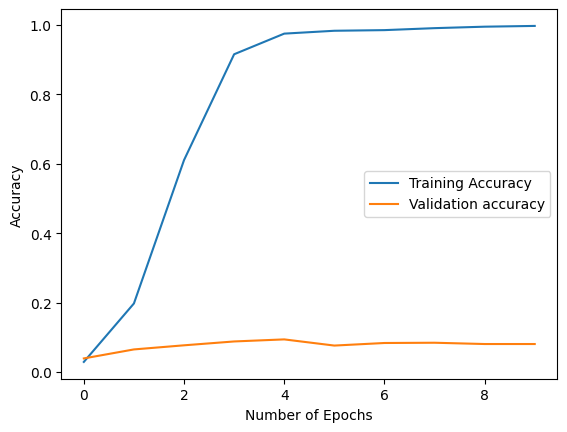

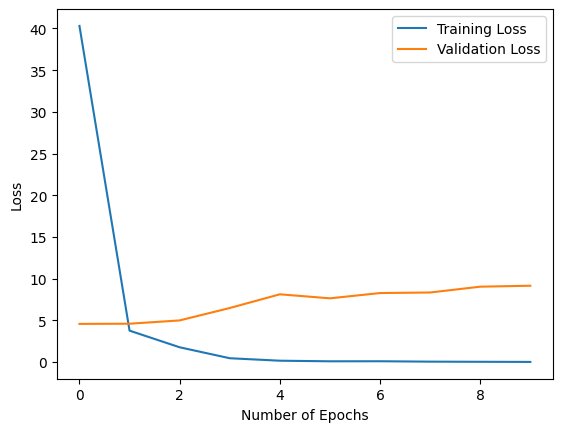

In [20]:
# plot history of trained model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation accuracy'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.show()

In [18]:
# loading pre-saved model
model = keras.models.load_model(filepath='models/model1_notshuffled.h5')

In [19]:
# evaluating model
model.evaluate(x=datagen_train, verbose=2)

548/548 - 71s - loss: 0.1295 - accuracy: 0.9819 - 71s/epoch - 130ms/step


[0.12950174510478973, 0.9819343090057373]

In [20]:
#compare predicted labels to test_labels
# add confusion matrix, training history


# only one batch
# datagen_test.on_epoch_end()
# x_test, y_true = datagen_test.__getitem__(0)

# y_predict = model.predict(x_test)

# y_true = tf.argmax(input=y_true, axis=1)
# y_predict = tf.argmax(input=y_predict, axis=1)


y_predict = model.predict(x=datagen_test)

print(len(y_predict))
#y_true = datagen_test.
y_predict = tf.argmax(input=y_predict, axis=1)


193/193 [==============================] - 15s 76ms/step
1351


In [21]:
#print(tf.print(y_predict))
x = list(np.array(y_predict))
print(x)
print(len(x))

print(list(test_labels.values()))
print(len(test_labels))


# print(y_predict)
# print(y_true)

[94, 20, 36, 46, 7, 101, 70, 94, 76, 7, 94, 81, 92, 92, 40, 35, 48, 58, 27, 79, 79, 36, 81, 40, 40, 81, 48, 95, 20, 0, 50, 64, 47, 36, 36, 100, 64, 3, 81, 19, 69, 42, 48, 77, 28, 94, 68, 76, 18, 79, 77, 80, 33, 88, 59, 73, 50, 30, 64, 91, 56, 88, 20, 59, 74, 35, 42, 81, 28, 7, 80, 75, 27, 36, 87, 36, 20, 77, 60, 75, 79, 42, 7, 76, 20, 80, 88, 40, 40, 55, 51, 81, 81, 75, 76, 50, 33, 76, 81, 57, 76, 50, 29, 44, 4, 81, 76, 76, 80, 27, 27, 28, 77, 35, 55, 77, 80, 20, 37, 46, 100, 50, 57, 33, 68, 12, 20, 10, 80, 20, 44, 50, 38, 64, 80, 29, 44, 64, 43, 94, 92, 20, 65, 89, 55, 44, 64, 7, 20, 27, 94, 81, 28, 50, 83, 100, 51, 41, 79, 76, 83, 80, 29, 31, 94, 35, 14, 90, 7, 101, 63, 52, 46, 64, 20, 64, 75, 88, 76, 81, 53, 63, 97, 64, 74, 59, 73, 18, 49, 82, 50, 87, 50, 83, 40, 87, 20, 27, 20, 35, 70, 40, 68, 50, 20, 20, 27, 76, 59, 57, 75, 88, 94, 79, 43, 55, 77, 67, 90, 58, 20, 79, 94, 51, 34, 76, 20, 20, 31, 59, 93, 84, 18, 55, 79, 20, 20, 28, 90, 59, 20, 96, 48, 79, 42, 72, 80, 76, 59, 16, 80,

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# classification report
target_names = []
for i in range (1,103):
    target_names.append(f"flower_{i}")
    print(i)


#for some fuking reason it eauther doent work beacous of
#a. the probelm with batches described earlier
#b. even if i put porper #of batches, its throws error that it read 103 classes instead of 102
report = classification_report(y_true=list(test_labels.values()), y_pred=y_predict, target_names=target_names)

print(report)

# confiusion matrix
# cm = confusion_matrix(y_true, y_predict)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels='')
# disp.plot()
# matplotlib.pyplot.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


ValueError: Number of classes, 103, does not match size of target_names, 102. Try specifying the labels parameter